# Python 종 분포 모델링(SDM: Species Distribution Modeling)

## 섹션 1 | 설정 (Set up)

In [1]:
import os

os.getcwd() # 현재 작업 디렉토리

'C:\\Users\\bhyu'

In [2]:
os.chdir('D:\\GEODATA') # 작업 디렉토리 변경
os.getcwd() # 현재 작업 디렉토리

'D:\\GEODATA'

In [3]:
os.makedirs("INPUT", exist_ok=True) # 작업 디렉토리에 'INPUT(입력)' 폴더 생성
os.makedirs("OUTPUT", exist_ok=True) # 작업 디렉토리에 'OUTPUT(출력)' 폴더 생성

In [4]:
import geopandas as gpd # GeoPandas(지오판다스)
import shutil # shutil(shell utility, 쉘 유틸리티)
import glob # glob(글로브)

pip install --upgrade pip
pip install wheel
pip install pipwin
pipwin refresh

pipwin install gdal
pipwin install pyproj
pipwin install six
pipwin install rtree
pipwin install shapely
pipwin install fiona
pipwin install rasterio
pipwin install pandas
pipwin install geopandas
pipwin install numpy

pip install matplotlib
pip install xgboost
pip install lightgbm
pip install pyimpute

pipwin uninstall rtree
pip install rtree

In [5]:
# JTREE_TRAIN_VEC.csv를 'INPUT/' 폴더로 이동
for f in sorted(glob.glob('DATA/JTREE_TRAIN_VEC*')):
    shutil.copy(f,'INPUT/')

In [6]:
import pandas as pd

train_vec = pd.read_csv("INPUT/JTREE_TRAIN_VEC.csv")
train_vec.head()

,CLASS,bclim1,bclim10,bclim11,bclim12,bclim13,bclim14,bclim15,bclim16,bclim17,bclim18,bclim19,bclim2,bclim3,bclim4,bclim5,bclim6,bclim7,bclim8,bclim9
0,1.0,149.0,238.0,71.0,337.0,50.0,2.0,55.0,146.0,29.0,45.0,143.0,162.0,46.0,6649.0,344.0,-2.0,346.0,80.0,212.0
1,1.0,152.0,242.0,71.0,320.0,49.0,2.0,57.0,140.0,27.0,37.0,138.0,164.0,46.0,6811.0,350.0,-3.0,353.0,81.0,217.0
2,1.0,170.0,266.0,82.0,338.0,52.0,5.0,45.0,118.0,26.0,91.0,103.0,183.0,48.0,7302.0,372.0,-7.0,379.0,264.0,196.0
3,1.0,143.0,231.0,66.0,371.0,57.0,2.0,59.0,165.0,30.0,43.0,161.0,162.0,47.0,6597.0,337.0,-7.0,344.0,74.0,205.0
4,1.0,188.0,301.0,80.0,99.0,12.0,2.0,33.0,32.0,12.0,24.0,30.0,154.0,38.0,8623.0,397.0,1.0,396.0,101.0,229.0


## 섹션 2 | 종 적합성(Species suitability) 매핑

In [7]:
# 조슈아 트리 연구지역으로 자른 생물 기후 특징
for f in sorted(glob.glob('DATA/BIOCLIM/bclim*.asc')):
    shutil.copy(f,'INPUT/')

In [8]:
# 래스터 특징
raster_features = sorted(glob.glob(
    'INPUT/bclim*.asc'))
print(raster_features)

['INPUT\\bclim1.asc', 'INPUT\\bclim10.asc', 'INPUT\\bclim11.asc', 'INPUT\\bclim12.asc', 'INPUT\\bclim13.asc', 'INPUT\\bclim14.asc', 'INPUT\\bclim15.asc', 'INPUT\\bclim16.asc', 'INPUT\\bclim17.asc', 'INPUT\\bclim18.asc', 'INPUT\\bclim19.asc', 'INPUT\\bclim2.asc', 'INPUT\\bclim3.asc', 'INPUT\\bclim4.asc', 'INPUT\\bclim5.asc', 'INPUT\\bclim6.asc', 'INPUT\\bclim7.asc', 'INPUT\\bclim8.asc', 'INPUT\\bclim9.asc']


In [9]:
# 래스터 특징 수 확인
print(len(raster_features), '개 래스터 특징')

19 개 래스터 특징


In [10]:
# pyimpute 모듈
from pyimpute import load_targets

In [11]:
train_xs, train_y = train_vec.iloc[:,1:20].values, train_vec.iloc[:,0].values # 훈련 데이터 로드
target_xs, raster_info = load_targets(raster_features) # scikit-learn용 데이터 구조로 래스터 특징 로드
train_xs.shape, train_y.shape # 관측치 크기와 일치하는지 shape 확인

((7200, 19), (7200,))

In [12]:
# ML 분류기 로드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [13]:
# ML 분류기 딕셔너리: 이름, (모델)
CLASS_MAP = {
    'RF': (RandomForestClassifier()),
    'ET': (ExtraTreesClassifier()),
    'XGB': (XGBClassifier()),
    'LGBM': (LGBMClassifier())
    }

In [14]:
# pyimpute, sklearn 로드
from pyimpute import impute
from sklearn import model_selection

In [15]:
# 모델 피팅 및 공간 예측(model fitting and spatial range prediction)
for name, (model) in CLASS_MAP.items():
    # 교차 검증(cross validation)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold 교차 검증 정확도: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # 공간 예측(spatial prediction)
    model.fit(train_xs, train_y)
    os.mkdir('OUTPUT/' + name + '-IMAGES')
    impute(target_xs, model, raster_info, outdir='OUTPUT/' + name + '-IMAGES',
           class_prob=True, certainty=True)

RF 5-fold 교차 검증 정확도: 90.06 (+/- 6.89)
ET 5-fold 교차 검증 정확도: 89.76 (+/- 7.56)
XGB 5-fold 교차 검증 정확도: 90.08 (+/- 7.12)
LGBM 5-fold 교차 검증 정확도: 90.26 (+/- 7.52)


In [16]:
import rasterio
distr_rf = rasterio.open("OUTPUT/RF-IMAGES/probability_1.0.tif").read(1)
distr_et = rasterio.open("OUTPUT/ET-IMAGES/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("OUTPUT/XGB-IMAGES/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open("OUTPUT/LGBM-IMAGES/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4

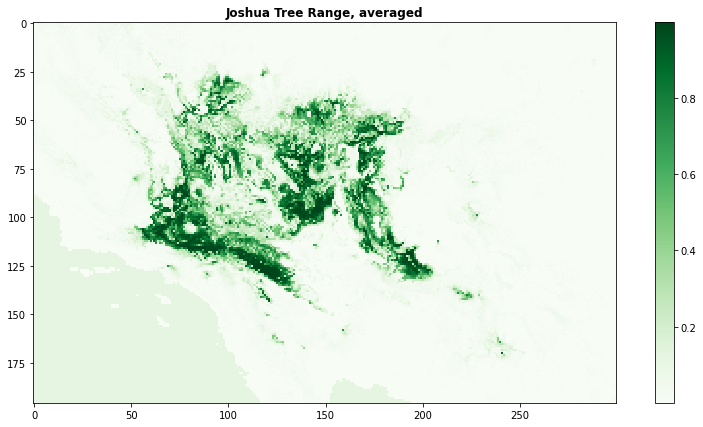

In [17]:
# 종 적합성 매핑의 평균값 가시화
from pylab import plt

def plotit(x, title, cmap="Blues"):
    plt.figure(figsize = (14,7))
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

plotit(distr_averaged, "Joshua Tree Range, averaged", cmap="Greens")

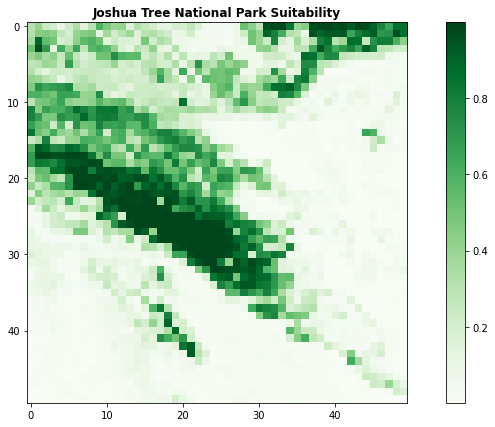

In [18]:
# 조슈아 트리 국립공원의 종 적합성 가시화
plotit(distr_averaged[100:150, 100:150], "Joshua Tree National Park Suitability", cmap="Greens")